# Final Project: Bahia Almirante Coral PSM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy
import numpy.ma as ma
from os import listdir, chdir
from os.path import isfile, join
import string
import sys
from math import exp
from pylab import *
import seaborn as sns
import csv
from numpy import genfromtxt
import os
from datetime import timedelta
import pandas as pd

import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

# import cartopy.crs as ccrs
# from cartopy.util import add_cyclic_point

# import hvplot.xarray
# import geoviews as gv
# import geoviews.feature as gf

import warnings
warnings.filterwarnings("ignore")

# Figures
import matplotlib.pyplot as plt

In [ ]:
dir = '/content/drive/MyDrive/EEPS_634_Final/data/' # YOUR CODE HERE

The coral proxy system model uses sea surface temperature and salinity OR $\delta^{18}O$ of seawater.

In [ ]:
# Sylvia Dee <sdee@usc.edu>
# PSM d18O Coral Aragonite
# SENSOR MODEL
# Function 'pseudocoral'
# Modified 10_16_2015 <sdee@usc.edu>
# Modified 11_17_2015 <sylvia_dee@brown.edu>
#====================================================================

def pseudocoral(lat,lon,SST,SSS,d18O=-1,species="default",b1=0.3007062,b2=0.2619054,b3=0.436509,b4=0.1552032,b5=0.15):

    """
        DOCSTRING: Function 'pseudocoral' produces a d18O-coral record given SST, SSS, and global position.
           The function is based on the forward model published by [Thompson, 2011]:
           <Thompson, D. M., T. R. Ault, M. N. Evans, J. E. Cole, and J. Emile-Geay (2011),
           Comparison of observed and simulated tropical climate trends using a forward
           model of coral \u03b418O, Geophys.Res.Lett., 38, L14706, doi:10.1029/2011GL048224.>
           Returns a numpy array that is the same size and shape as the input vectors for SST, SSS.

        Input parameters:
            Latitude    [lat]       [-90, 90]
            Longitude   [lon]       [0, 360]
            SST         [SST]       SST ANOMALY Units = degrees Celsius
            SSS         [SSS]       SSS ANOMALY Units = PSU
            Please note that input files must be read in as 1-D vectors.

        Output:
            Returns a Numpy Array, ['coral'], which is saved in the main program.
            Optional Inputs: Please note that the function will use default params for
            d18O vs. SSS, a, and b unless specified and placed in the appropriate location as shown below.
            delta_18O [permil]: If the user does not have an input field for d18O, you must put -1 in its
            position in the call and use the equation for SSS below.

            **Note: [always use d18O (seawater) if available!]**

            The user may specify values for parameters a and b in the coral d18O forward model,
            which are currently set to the following default values:

            a = coral - SST regression, accounting for species-dependent variations in the SST-18O dependence.
            The code assigns this value universally at -.22, but published values vary by species/genus (i.e. Moses, 2006)
            Specify keyword input 'species=' to set slope:
            species =
                    "Default":      a = -0.22
                    "Porites_sp":   a = -.26178
                    "Porites_lob":  a = -.19646
                    "Porites_lut":  a = -.17391
                    "Porites_aus":  a = -.21
                    "Montast":      a = -.22124
                    "Diploas":      a = -.14992

            b = d18O-SSS slope, as defined by location in: Legrande & Schmidt, (2006)
                    <LeGrande, A. N., and G. A. Schmidt (2006), Global gridded data set of the oxygen isotopic          composition in seawater, Geophys. Res. Lett., 33, L12604, doi:10.1029/2006GL026011.>
                    b1 = 0.31   [Red Sea]
                    b2 = 0.27   [Tropical Pacific]
                    b3 = 0.45   [South Pacific]
                    b4 = 0.16   [Indian Ocean]
                    b5 = 0.15   [Tropical Atlantic Ocean/Caribbean]
        Example of use: Call function 'pseudocoral' to calculate d18O_coral timeseries, lacking d18O sw
        but specifying own numeric parameters for a, b.
        pseudocoral(lat,lon,SST,SSS,-1,species="default",b1,b2,b3,b4,b5)
    """
#====================================================================



# Define slope of coral response to SST, a
    #Also, have you considered accounting for species-dependent variations in the a1 value (the SST-18O dependence)?
    #The code assigns this value universally at -.22, but published values vary by species/genus (i.e. Moses, 2006).
    #I've copied and pasted a chunk of code from one of my scripts that does this brute-force... Hope it helps.

    #if species == "Porites_sp":
        #a=-.26178
    #elif species == "Porites_lob":
        #a=-.19646
    #elif species == "Porites_lut":
        #a=-.17391
    #elif species == "Porites_aus":
        #a=-.21
    #elif species== "Montast":
        #a=-.22124
    #elif species == "Diploas":
        #a=-.14992
    #elif species == "default":
        #a=-0.22
    #else:
    a=-0.22

# Define SSS-d18O(sw) slopes by region. Note that we multiply all slopes by VPDB/VSMOW [0.0020052/0.0020672] ~ 0.97 to correct d18O values.

# Because d18Osw is reported relative to VSMOW, we have to convert the slope to VPDB so
# that the units of the forward model output are in VPDB (and thus directly comparable
# to published d18O records, in units of VPDB). The way this affects the forward model is
# in the d18Osw-SSS slope.

    V_corr = 0.97002

    slope1 = V_corr*b1      # Red Sea
    slope2 = V_corr*b2      # Tropical Pacific
    slope3 = V_corr*b3      # South Pacific
    slope4 = V_corr*b4      # Indian Ocean
    slope5 = V_corr*b5      # Tropical Atlantic

# Given Lat/Lon pair, assign correct value to 'b'
    if lon>=32.83 and lon<=43.5 and lat>=12.38 and lat<=28.5:    # Red Sea
        b=slope1
    elif lon<=120.:              # Indian Ocean
        b=slope4
    elif lon>=270. and lat>=9.:    #Tropical Atlantic ~300 E longitude
        b=slope5
    elif lat> -5. and lat<=13.:   # Tropical Pacific
        b=slope2
    elif lat<= -5.:              # South Pacific
        b=slope3
    else:
        b=slope2            # Default = Trop. Pacific.

#====================================================================

# Form an array of pseudocoral data

    if d18O==-1:
        coral = a*SST+b*SSS
    else:
        coral = a*SST + d18O

#====================================================================

    return coral

In [ ]:
#!/usr/bin/env python
# Sylvia Dee <sdee@usc.edu>, Modified by Weidai Sun <ws62@rice.edu> for the purpose of Paleoclimate final project
# Modified 4/25/13
# psm.coral.env
#====================================================================

"""
CORAL PSM DRIVER SCRIPT

Data preparation script to generate simulated proxy data.
This file loads input files and environmental variables and calls
the forward model functions (sub-models).

This wrapper script prepares forward model environmental input files, which
must contain spatial information (lat, lon) and puts them into
an appropriate format that the function handles (vectors only)!

Please read docstring carefully for each function call before use.

# CORALS: calculating d18O anomalies from SST and SSS anomalies.
"""
#====================================================================
# 1. LOAD CLIMATE FIELDS
#====================================================================
df = pd.read_csv(dir+"df")

# Load SST anomalies [C] (NOTE: THIS SHOULD BE A 1-D VECTOR OF DATA!)
sst = np.array(df['SST_anomalies'])

# Load SSS anomalies [psu] (NOTE: THIS SHOULD BE A 1-D VECTOR OF DATA!)
sss = np.array(df['SSS_anomalies'])

# set time axis
time = np.array(df['Date'])

In [ ]:
#====================================================================
# 2. DATA PREP: Exception Handling
#====================================================================
print('Preparing data...')
# 2.1 Convert Lats and Lons to standard format (if they aren't already).

# lon: convert (-180: +180) to (0: 360)
# lat: convert (0: 180) to (-90: +90)

# Enter your coordinates here:
lon=-82.256565
lat=9.351553

# make sure there are no negative-longitude coordinates: [0 to 360] only.
# longitude
if (lon<0.):
    lon = lon+360.

# latitude
if (lat>90.):
    lat = lat-90.

# 2.2 Ensure that Sea-Surface Temperature is in degrees C, not Kelvin.

Preparing data...


In [ ]:
#====================================================================
# 3. CALL SENSOR MODEL: Call function 'pseudocoral' (see doc) to compute pseudocoral
#    timeseries.
#====================================================================

# NOTE: THIS SHOULD BE A 1-D VECTOR OF DATA!
print('Running sensor model...')
coral = np.zeros(len(time))  # this will initialize a [Time x Lat x Lon] matrix of coral values.

# Fill coral array with data same size as input vectors.
# Important: if you have d18O of seawater, add a 5th argument 'd18O' and input data as vector array (default is -1).
# Inputs: lat, lon, SST, SSS OR d18O
# Optional d18O/T slope parameters:
# a= -0.22,b1=0.3007062,b2=0.2619054,b3=0.436509,b4=0.1552032 (see doctring)

for i in range(len(time)):
    coral[i] = pseudocoral(lat,lon,sst[i],sss[i])


Running sensor model...


We've run the Coral PSM! Great. Let's plot the coral timeseries.



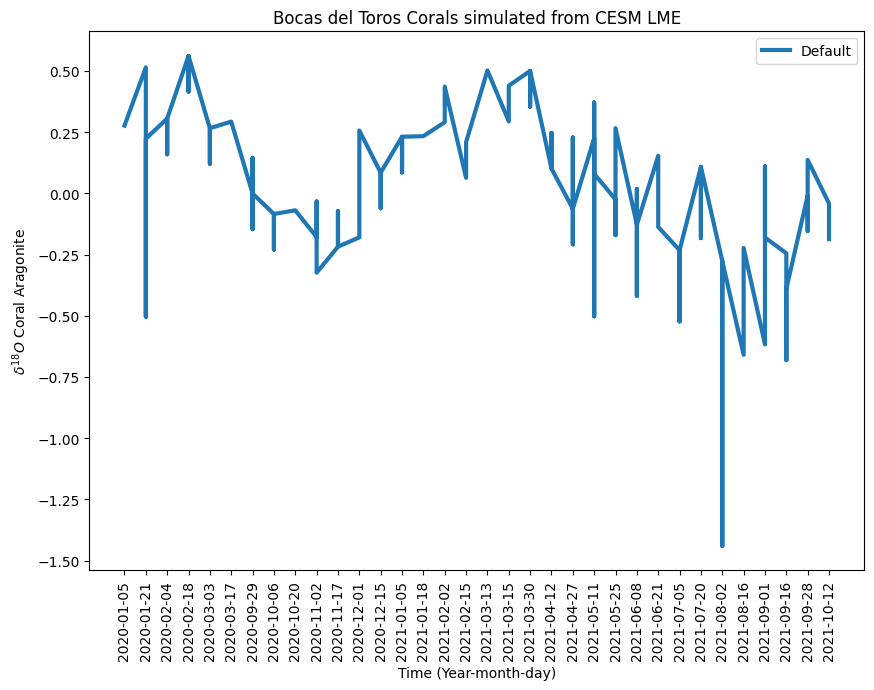

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(10, 7))
plt.plot(time,coral,label="Default",linewidth=3)

plt.xlabel('Time (Year-month-day)')
plt.ylabel('$\delta^{18}O$ Coral Aragonite')
plt.title('Bocas del Toros Corals simulated from CESM LME')
plt.xticks(rotation=90)
plt.legend()

Now, let's experiment with changing the inputs and seeing how it alters the output.  How does the PSM simulate different species of corals? Change the input and plot them together. I've given you two examples below, but why not test 5? 🔥


This version of the PSM is using salinity, but we have isotope enabled models as well, if you ever need to run this with the $\delta^{18}O$ of seawater.


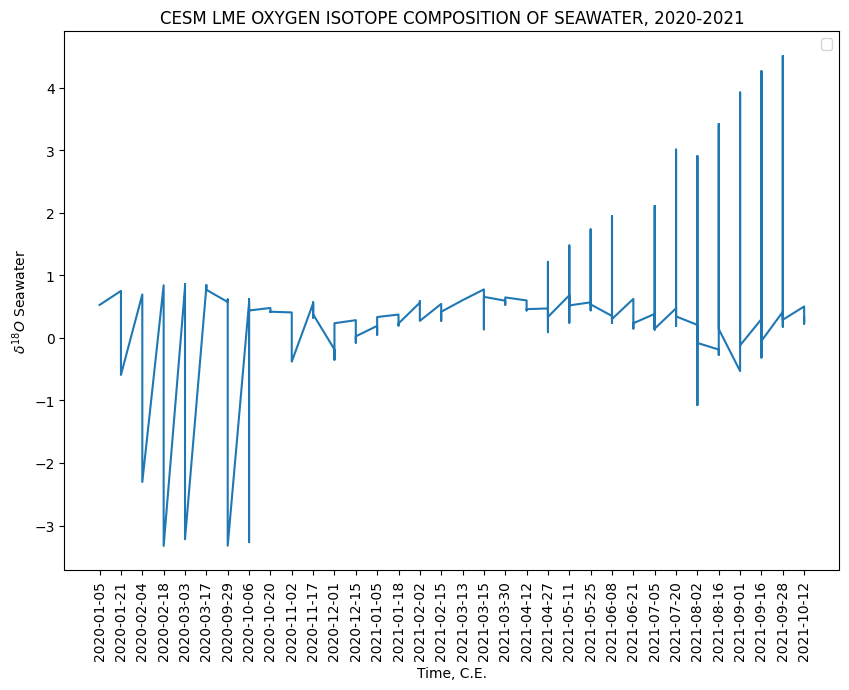

In [ ]:
# YOUR CODE HERE

d18Osw=np.array(df['d18O_cal_opt'])
d18Osw_time=np.array(df['Date'])

# TITLE: CESM LME OXYGEN ISOTOPE COMPOSITION OF SEAWATER, 2020-2021.
plt.figure(figsize=(10, 7))
plt.plot(d18Osw_time,d18Osw)
plt.xlabel('Time, C.E.')
plt.ylabel('$\delta^{18}O$ Seawater')
plt.xticks(rotation=90)
plt.title('CESM LME OXYGEN ISOTOPE COMPOSITION OF SEAWATER, 2020-2021')
plt.legend()

- Yes it is consistent because the VSMOW standard of oxygen isotope came from the oxygen isotope ratio of the ocean.

In [ ]:
# Load d18O of seawater

coral_sw = np.zeros(len(time))  # this will initialize a [Time x Lat x Lon] matrix of coral values.


for i in range(len(time)):
    coral_sw[i] = pseudocoral(lat,lon,sst[i],sss[i],d18O=d18Osw[i])

Plot the coral PSM time series using salinity as an input vs. d18Osw.

Compare them. Are they similar or different? Plot a PDF of these two time series in the same figure.

- They are very similar but slightly different in the peaks values.

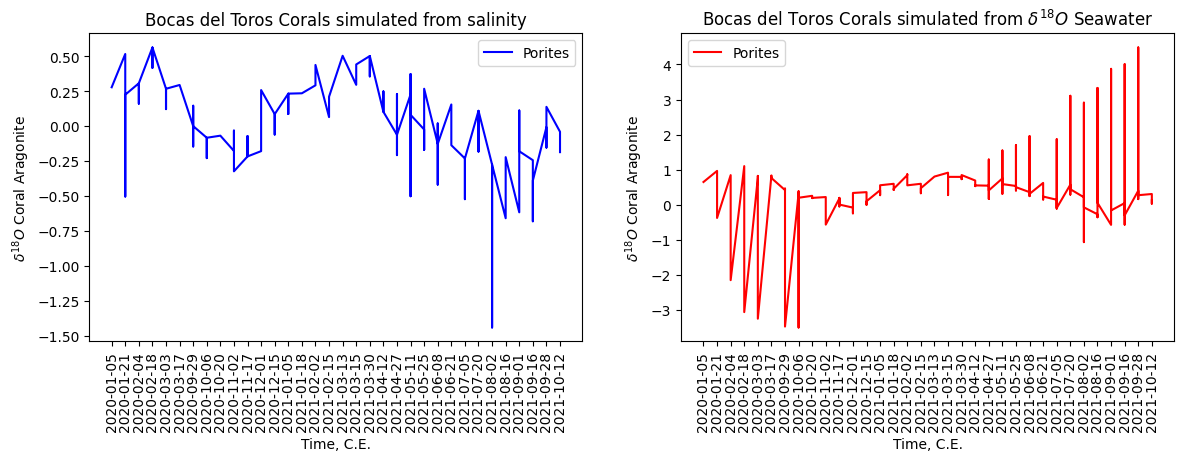

In [ ]:
# YOUR CODE HERE

# TIME SERIES COMPARISON
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 4))

ax1.plot(time, coral, color='blue', label = 'Porites')
ax1.set_title('Bocas del Toros Corals simulated from salinity')
ax1.set_xlabel('Time, C.E.')
ax1.set_ylabel('$\delta^{18}O$ Coral Aragonite')
ax1.tick_params(axis='x', rotation=90)
ax1.legend()

ax2.plot(time, coral_sw, color='red', label = 'Porites')
ax2.set_title('Bocas del Toros Corals simulated from $\delta^{18}O$ Seawater')
ax2.set_xlabel('Time, C.E.')
ax2.set_ylabel('$\delta^{18}O$ Coral Aragonite')
ax2.tick_params(axis='x', rotation=90)
ax2.legend()

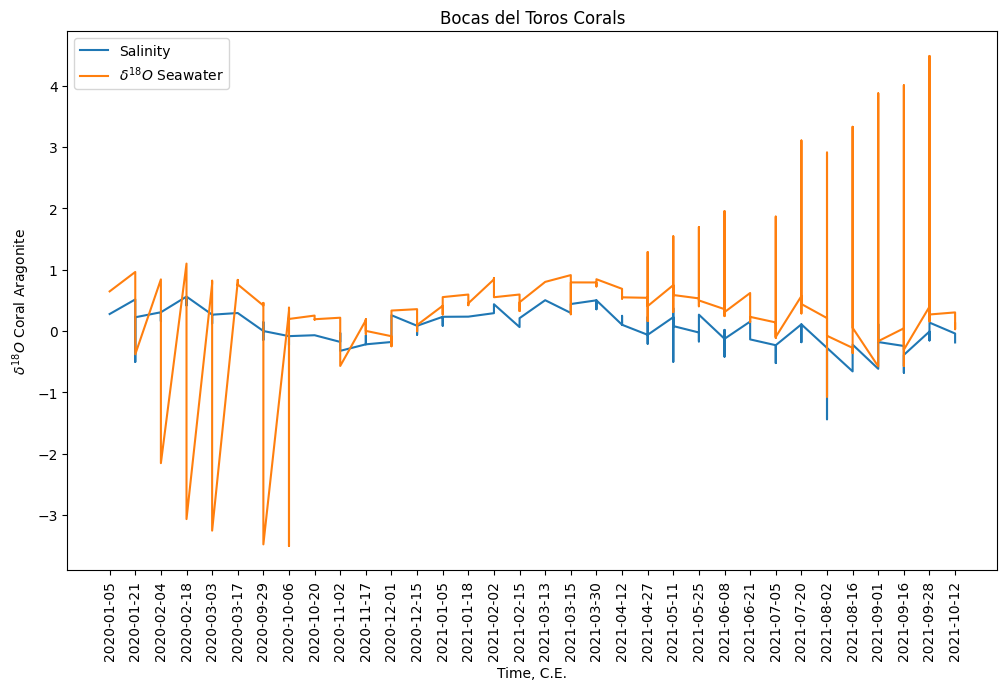

In [ ]:
# PDFs
plt.figure(figsize=(12, 7))
plt.plot(time,coral,label = 'Salinity')
plt.plot(time,coral_sw,label = '$\delta^{18}O$ Seawater')

plt.xlabel('Time, C.E.')
plt.ylabel('$\delta^{18}O$ Coral Aragonite')
plt.title('Bocas del Toros Corals')
plt.xticks(rotation=90)
plt.legend()
#plt.savefig("/content/drive/MyDrive/EEPS_634_figs/coral_PSM_time_series_salinity_vs_d18Osw.pdf",format="pdf")

# Separate by locations

In [ ]:
# 1. Load in datasets and sample preparation: lat/lon the same
locations = ["Almirante", "Colon_Norte", "Cristobal", "Drago", "Pastores", "STRI"]
df_loc = {}
for loc in locations:
    data = pd.read_csv(dir+loc)
    df_loc[loc] = {
        "sst": np.array(data['SST_anomalies']),
        "sss": np.array(data['SSS_anom_ind']),
        "trueSSS": np.array(data['SSS']),
        "d18O": np.array(data['d18O_cal_opt']),
        "time": np.array(data['Date'])
    }

In [ ]:
# 3. Sensor model
for loc in df_loc:
  each = df_loc[loc]
  sst = each['sst']
  sss = each['sss']
  trueSSS = each['trueSSS']
  d18Osw = each['d18O']
  coral_sss = np.zeros(len(each['time']))
  coral_d18Osw = np.zeros(len(each['time']))

  for i in range(len(each['time'])):
      coral_sss[i] = pseudocoral(lat,lon,sst[i],sss[i])
      coral_d18Osw[i] = pseudocoral(lat,lon,sst[i],sss[i],d18O=d18Osw[i])
  each['coral_sss'] = coral_sss
  each['coral_d18Osw'] = coral_d18Osw


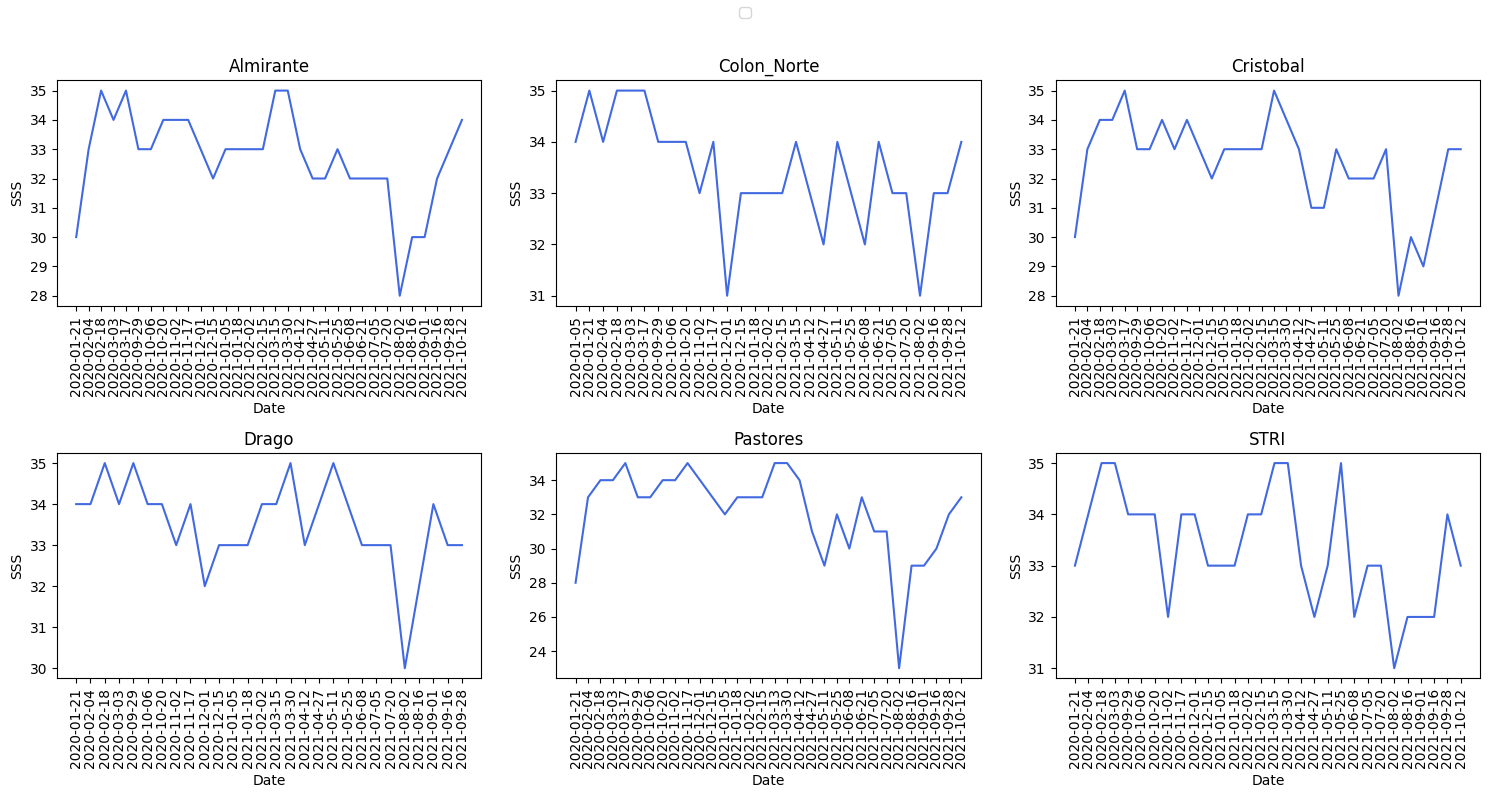

In [ ]:
# Plot d18O of seawater
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)


for ax, loc in zip(axes.ravel(), locations):
    each = df_loc[loc]

    ax.plot(each["time"], each["trueSSS"], color="royalblue")

    ax.set_title(loc)
    ax.set_xlabel("Date")
    ax.set_ylabel("SSS")
    ax.tick_params(axis='x', rotation=90)

# One legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

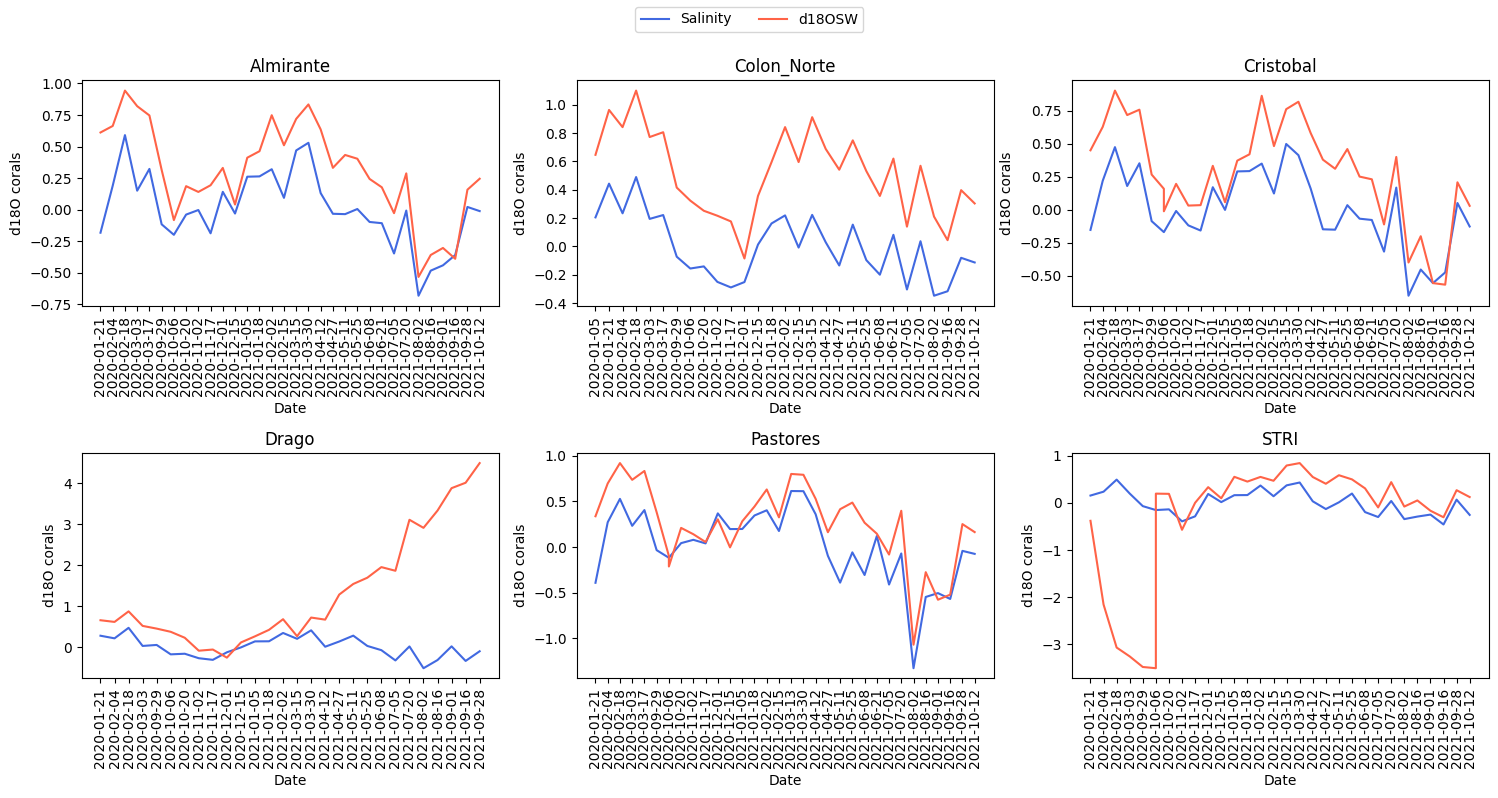

In [ ]:
# Plot d18O corals
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)


for ax, loc in zip(axes.ravel(), locations):
    each = df_loc[loc]

    ax.plot(each["time"], each["coral_sss"], label="Salinity", color="royalblue")
    ax.plot(each["time"], each["coral_d18Osw"], label="d18OSW", color="tomato")

    ax.set_title(loc)
    ax.set_xlabel("Date")
    ax.set_ylabel("d18O corals")
    ax.tick_params(axis='x', rotation=90)

# One legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()